In [24]:
import numpy as np
import pandas as pd
import os
from scipy import signal
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
sns.set()
%matplotlib inline

# Import & Process data

In [25]:
# Known Dataset
Caravan_train = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/Caravan_train.csv")
# Converts data set to matrix
data = np.matrix(Caravan_train)
Features = Caravan_train.dtypes.index
X_features = Features.drop('Purchase')

# Unknown Dataset
Caravan_unk = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/Caravan_unk.csv")
# Converts data set to matrix
data_uk = np.matrix(Caravan_unk)

In [26]:
# Change Categroical data to dummy variable 0 and 1
y = []
for i in range(len(data)):
    y.append(data[i,85])
    
for i in range(len(y)):
    if y[i] == 'Yes':
        y[i]=1
    else:
        y[i]=0

# Create subdatsets X(features) and y(target)      
X = pd.DataFrame(data[:,:85], columns = X_features)
y = pd.DataFrame(y, columns = ['Purchase'])

X_uk = pd.DataFrame(data_uk[:,:85], columns = X_features)

# Split into training and testing (default: 75%, 25%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Find frequency of labels to determine if data is imbalenced. 
Caravan_train['Purchase'].value_counts()

No     4346
Yes     284
Name: Purchase, dtype: int64

# Model Evaluations
- K-Nearest Neighbor
- Logistic Regression
- Naive Bayes
- Decision Tree
- Gradient Boosting Classifier
- Support Vector Machine

## K-Nearest Neighbor

Summary of model:

K - Nearest Neighbor models work by plotting the testing data along side the known training data. The alogorithm finds the K nearest points and assigns the majority class to the data point with the unkown target. This is how the salary class is predicted for this dataset. 

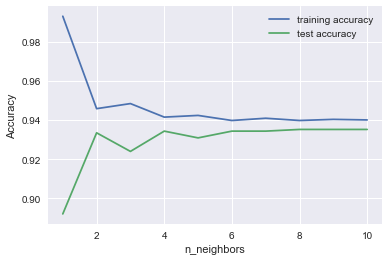

In [27]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, np.ravel(y_train))
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, np.ravel(y_test)))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

The plot shows that n = 9 nearest neighbors will result in the best training and testing accuracy.

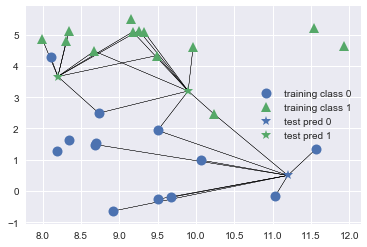

In [28]:
# ROC curve and AUC for KNN model with varying n
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train, np.ravel(y_train))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))

mglearn.plots.plot_knn_classification(n_neighbors=9)

The plot above shows a visualization of the KNN model. 

Training set accuracy: 0.94

Test set accuracy: 0.94

AUC for KNN: 0.500


Text(0,0.5,'TPR (recall)')

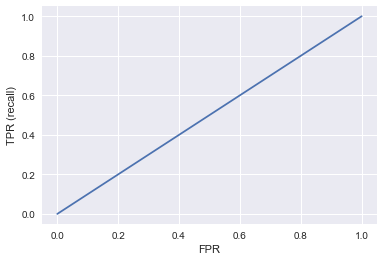

In [29]:
KNNtra = clf.score(X_train, np.ravel(y_train))
KNNtea = clf.score(X_test, np.ravel(y_test))
KNNauc = roc_auc_score(np.ravel(y_test), clf.predict(X_test))

print("Training set accuracy: {:.2f}\n".format(clf.score(X_train, np.ravel(y_train))))
print("Test set accuracy: {:.2f}\n".format(clf.score(X_test, np.ravel(y_test))))
print("AUC for KNN: {:.3f}".format(KNNauc))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The testing and training accuracy of this model is around 94% which at first appears to be moderately high. Upon further inspection from the AUC metric, it can be shown that in reality this model is no barely better than a coin toss. 

Model Pros & Cons:

The car insurance data is highly imbalanced which is the reason for such a low AUC score. The K-NN model is very senstive to the balance of the variables becuase this will impact the majority amongst neighbors around observations which is what drives the KNN model. In cases such as these, if the model simply predicts 0 100% of the time we will see a misleadingly high testing accuracy rate. For this reason, a K-NN model would not be a good choice for this dataset.  

## Logistic Regression

Summary of model:

Logistic regression models the probability that Y belongs to a particular class. For this dataset, logistic regression will model the probability of having a salary greater than 50k given the sociodemographic data. Logistic regression differd from linear regression in that it is bounded by 0 and 1 by an exponential fucntion:

$$ log[p(X)/(1 -p(X)] = A + BX $$

Where A and B are the regression coefficients. 

Training accuracy of l1 logreg with C=0.001: 0.94
Test accuracy of l1 logreg with C=0.001: 0.94
Training accuracy of l1 logreg with C=1.000: 0.94
Test accuracy of l1 logreg with C=1.000: 0.93
Training accuracy of l1 logreg with C=100.000: 0.94
Test accuracy of l1 logreg with C=100.000: 0.93


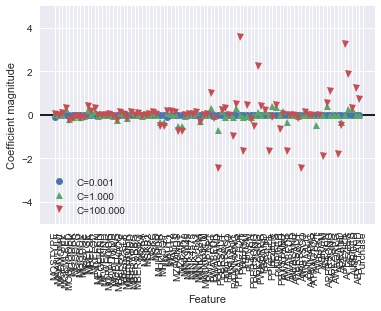

In [31]:
from sklearn.linear_model import LogisticRegression

for C, marker in zip([0.001,1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(C=C, penalty="l1").fit(X_train, np.ravel(y_train))
    print("Training accuracy of l1 logreg with C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_train, np.ravel(y_train))))
    print("Test accuracy of l1 logreg with C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_test, np.ravel(y_test))))
    plt.plot(lr_l1.coef_.T, marker, label="C={:.3f}".format(C))

plt.xticks(range(data.shape[1]),Features, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.ylim(-5, 5)
plt.legend(loc=3)

The plot above shows how different shrink values impact the 85 features. It can be seen from this that the green distribution (C = 1) is a good middle ground between total shrink (Coefficient = 0) and total chaos at C = 100. For further inspection, we will see how the testing and training accuracies differ at different C values in the next block. 

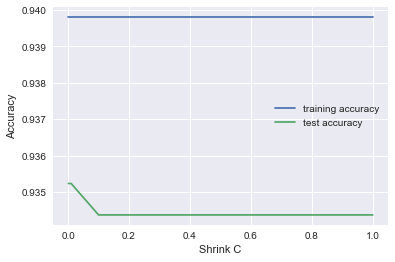

In [32]:
training_accuracy = []
test_accuracy = []
# try C from 0.0001 to 100
C = [0.001, 0.01, 0.1, 1]
for C in C:
    # build the model
    logreg = LogisticRegression(C=C).fit(X_train, np.ravel(y_train))
    # record training set accuracy
    training_accuracy.append(logreg.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(logreg.score(X_test, np.ravel(y_test)))

C = [0.001, 0.01, 0.1,1]
plt.plot(C, training_accuracy, label="training accuracy")
plt.plot(C, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Shrink C")
plt.legend()

Upon further inspection of the hyperparameter it appears that the C value does not impact the model accuracy too mcuh. Becuase of this, a shrink value of 1 will be used for building the model. 

Training set score: 0.940
Test set score: 0.934
AUC for logreg: 0.729


Text(0,0.5,'TPR (recall)')

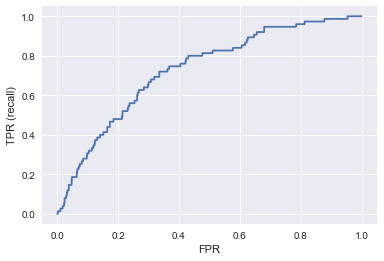

In [35]:
logreg = LogisticRegression(C=1).fit(X_train, np.ravel(y_train))
pred_logreg = logreg.predict(X_test)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    np.ravel(y_test), logreg.decision_function(X_test))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), logreg.decision_function(X_test))


LRtra = logreg.score(X_train, np.ravel(y_train))
LRtea = logreg.score(X_test, np.ravel(y_test))
LRauc = roc_auc_score(np.ravel(y_test), logreg.decision_function(X_test))


print("Training set score: {:.3f}".format(logreg.score(X_train, np.ravel(y_train))))
print("Test set score: {:.3f}".format(logreg.score(X_test, np.ravel(y_test))))
print("AUC for logreg: {:.3f}".format(LRauc))

# Plot TPR versus FPR for every threshold
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The results of this model appear to be satisfactory from the testing and training accuracy score of about 94% and an AUC of about 0.72. The logistic regression uses the probability rather than the mojority, so it makes sense that this model is less affected by the imbalanced data. This is one of the advantages of Logisitic Regression because it's output is a probability and can be used for ranking as well as classifying.

## Naive Bayes

Summary of model:

The Naive Bayes model works by modeling the distribution of each predictor X for each class of y and then uses Bayes Theorem to convert the ditribution into a probability using the equation below:

$$ [f(X | y)f(y)] /  f(X) $$

Training set score: 0.147
Test set score: 0.153
AUC for NB: 0.528


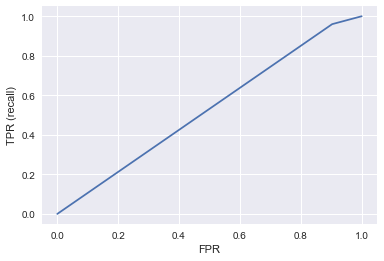

In [36]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, np.ravel(y_train))
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), NB.predict(X_test))

NB_predict = NB.predict(X_test)
NB_prob = NB.predict_proba(X_test)
NB_prob[:].round(3)

NBtra = NB.score(X_train, np.ravel(y_train))
NBtea = NB.score(X_test, np.ravel(y_test))
NBauc = roc_auc_score(np.ravel(y_test), NB.predict(X_test))

print("Training set score: {:.3f}".format(NBtra))
print("Test set score: {:.3f}".format(NBtea))
print("AUC for NB: {:.3f}".format(NBauc))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

y_pred = NB.fit(X, np.ravel(y)).predict(X)
#print("Number of mislabeled points out of a total %d points : %d"
      #%(data.shape[0],(y != y_pred).sum()))

Results:

The results of this model are similar to those of K-NN. The model training and testing accuracy are high but the AUC is low. This could be due to the variable distribution being skewed. 

Model Pros & Cons:

Bayes theorem assumes a normal gaussian distribution and that all predictors are independent. These assumptions and simplifications might not be applicable to this dataset which could be the source of the error in the model as suggested by the ROC curve. Consequently, this is one of the disadvantages of Naive Bayes. 

## Decision Tree

Summary of model:

Decision tree models work by prediciting a response for an observation that belongs to the most commonly occuring class of training observations in it's region. It then repeats this for a specified depth until a stopping criterion is reached. 

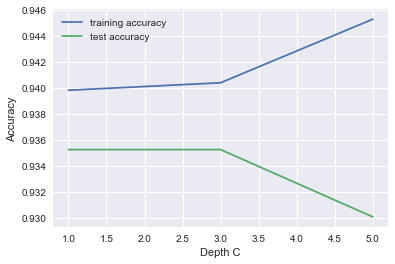

In [37]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

# using AUC to tune hyperparameter
training_accuracy = []
test_accuracy = []
# try C from 0.0001 to 100
D = np.arange(1,6,2)
for D in D:
    # build the model
    tree = DecisionTreeClassifier(max_depth=D, random_state=0)
    tree.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(tree.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(tree.score(X_test, np.ravel(y_test)))
    # record AUC
    tree_auc = roc_auc_score(np.ravel(y_test), tree.predict(X_test))
    

D = np.arange(1,6,2)
plt.plot(D, training_accuracy, label="training accuracy")
plt.plot(D, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Depth C")
plt.legend()

The plot shows that a max depth of 3 will result in the best training and testing accuracy.

Accuracy on training set: 0.940
Accuracy on test set: 0.935
AUC for treee: 0.500


Text(0,0.5,'TPR (recall)')

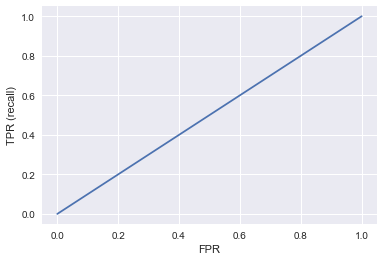

In [38]:
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X_train, y_train)
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), tree.predict(X_test))
tree_auc = roc_auc_score(np.ravel(y_test), tree.predict(X_test))

Treetra = tree.score(X_train, np.ravel(y_train))
Treetea = tree.score(X_test, np.ravel(y_test))
Treeauc = roc_auc_score(np.ravel(y_test), tree.predict(X_test))

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))
print("AUC for treee: {:.3f}".format(Treeauc))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The results of this tree model are more promising than previous models. All three metrics suggest a moderately effective model with an AUC score of 0.75. This indicates that the model had a significantly larger TPR than FPR. 

Model Pros & Cons:

Trees are great for simplicity and graphical displays of the dataset, but are very senstive to small changes in the data. Additionally, this model is driven by choosing a majority class for a region which will be highly skewed due to the imbalance in the data. One way to increase the performance of a tree is to apply the gradient booster, which will be modeled in the next section. 

## Gradient Boosting Classifier

Summary of model:

Boosting a decision tree model is done by growing trees based on information from the previous tree. Boosting builds trees on a modified version of the original dataset, it does not use bootstrapping like other decision tree models. 

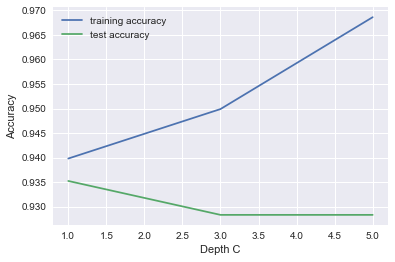

In [39]:
#Output graph of important features
from sklearn.ensemble import GradientBoostingClassifier

# using AUC to tune depth hyperparameter
training_accuracy = []
test_accuracy = []
# try C from 0.0001 to 100
D = np.arange(1,6,2)
for D in D:
    # build the model
    gbrt = GradientBoostingClassifier(random_state=0, max_depth=D)
    gbrt.fit(X_train, np.ravel(y_train))
    # record training set accuracy
    training_accuracy.append(gbrt.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(gbrt.score(X_test, np.ravel(y_test)))
    # record AUC
    fpr, tpr, thresholds = roc_curve(np.ravel(y_test), gbrt.decision_function(X_test))
    gbrt_auc = roc_auc_score(np.ravel(y_test), gbrt.decision_function(X_test))
    

D = np.arange(1,6,2)
plt.plot(D, training_accuracy, label="training accuracy")
plt.plot(D, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Depth C")
plt.legend()

The plot shows that a max depth of 1 will result in the best training and testing accuracy.

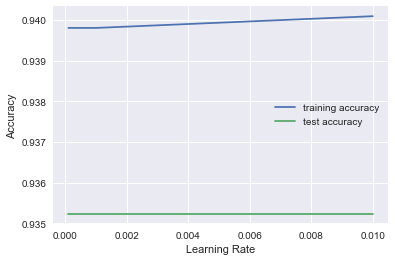

In [40]:
# using AUC to tune learning rate hyperparameter
training_accuracy = []
test_accuracy = []
# try C from 0.0001 to 100
rate = [0.0001,0.001,0.01]
for rate in rate:
    # build the model
    gbrt = GradientBoostingClassifier(random_state=0, learning_rate=rate)
    gbrt.fit(X_train, np.ravel(y_train))
    # record training set accuracy
    training_accuracy.append(gbrt.score(X_train, np.ravel(y_train)))
    # record generalization accuracy
    test_accuracy.append(gbrt.score(X_test, np.ravel(y_test)))
    # record AUC
    fpr, tpr, thresholds = roc_curve(np.ravel(y_test), gbrt.decision_function(X_test))
    gbrt_auc = roc_auc_score(np.ravel(y_test), gbrt.decision_function(X_test))
    

rate = [0.0001,0.001,0.01]
plt.plot(rate, training_accuracy, label="training accuracy")
plt.plot(rate, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Learning Rate")
plt.legend()

The plot shows that the learning rate does not affect the accuaracy rate significantly, so the default will be used.

Accuracy on training set: 0.940
Accuracy on test set: 0.935
AUC for gbrt: 0.783


Text(0,0.5,'TPR (recall)')

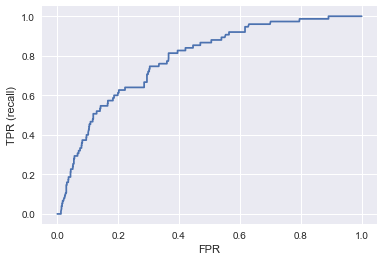

In [41]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth = 1)
gbrt.fit(X_train, np.ravel(y_train))
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), gbrt.decision_function(X_test))
gbrt_auc = roc_auc_score(np.ravel(y_test), gbrt.decision_function(X_test))

GBtra = gbrt.score(X_train, np.ravel(y_train))
GBtea = gbrt.score(X_test, np.ravel(y_test))
GBauc = gbrt_auc

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, np.ravel(y_train))))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, np.ravel(y_test))))
print("AUC for gbrt: {:.3f}".format(gbrt_auc))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The results of the gradient boosting classifier model are quite impressive. The model has a high accuracy rate in both training and testing data and the AUC score of 0.78 validates that it is an effective model for this data set. This indicates that the model predicts correctly a majority of the time.

Model Pros & Cons:

The advantages of using the gradient booster is that it makes the decision tree methodology more robust, which holds true in comparing the two models on this dataset. Additionally, becuase boosting takes into account the prior trees when creating new tress, it often can outperform random forests with a shallower depth parameter. Conversly, the disadvantages of using this kind of model is that it often is computationally more expensive due to it's greater learning capacity. 

## Support Vector Machine

Summary of model:

Support vector machines work by creating a linear boundary or margin between like clusters, and penalizing observations that cross these boundaries using a hyperparameter C. 

Accuracy on training set: 0.94
Accuracy on test set: 0.94
AUC for svc: 0.617


Text(0,0.5,'TPR (recall)')

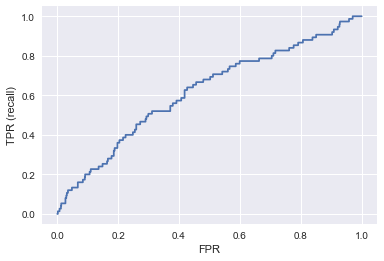

In [16]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, np.ravel(y_train))
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), svc.decision_function(X_test))
svc_auc = roc_auc_score(np.ravel(y_test), svc.decision_function(X_test))


SVCtra = svc.score(X_train, np.ravel(y_train))
SVCtea = svc.score(X_test, np.ravel(y_test))
SVCauc = svc_auc

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, np.ravel(y_train))))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, np.ravel(y_test))))
print("AUC for svc: {:.3f}".format(svc_auc))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

Results:

The results of this model are not ideal. The accuracies are misleadingly high when compared to the AUC which indicates that the model predicts wrongly quite often. 

Model Pros & Cons:

One disadvantage of SVC models is that they separate the data with a linear boundary, unlike Support Vector Machines which separate with non-linear boundaries. This makes SVM more robust for a wider range of datasets. 

# Summary of Results

In [44]:
KNN = [KNNtra, KNNtea, KNNauc,]
LR = [LRtra,LRtea,LRauc]
NB = [NBtra,NBtea,NBauc]
Tree = [Treetra,Treetea,Treeauc]
GB = [GBtra,GBtea,GBauc]
SVC = [SVCtra,SVCtea,SVCauc]

Train = [KNNtra,LRtra,NBtra,Treetra,GBtra,SVCtra]
Test = [KNNtea,LRtea,NBtea,Treetea,GBtea,SVCtea]
AUC = [KNNauc,LRauc,NBauc,Treeauc,GBauc,SVCauc]

data = [KNN , LR, NB, Tree, GB, SVC]
Table = pd.DataFrame({'Train': Train, 'Test': Test, 'AUC': AUC}, 
                     columns=['Train', 'Test','AUC'], 
                     index = ['K-NN','LogReg','Naive Bayes','Decision Tree', 'Grad. Boost.', 'SVC'] )
Table

,Train,Test,AUC
K-NN,0.940380,0.935233,0.500000
LogReg,0.939804,0.934370,0.728846
Naive Bayes,0.146601,0.152850,0.528476
Decision Tree,0.940380,0.935233,0.500000
Grad. Boost.,0.939804,0.935233,0.782893
SVC,0.940668,0.935233,0.617119


The table shows a comparison of the testing and training accuracy of the models, as well as the area under the curve (AUC) metric for determining a model's success. From this table it is clear that the Gradient Boosting Classifier model is most effective with an AUC of 0.78. I will use this model to predict the probability of customers purchasing insurance. 

In [45]:
# Build the model
gbrt = GradientBoostingClassifier(random_state=0, max_depth = 1)
# Fit the model to the known dataset
gbrt.fit(X, np.ravel(y))

# Predict the target of the unkown dataset
y_pred = gbrt.predict(X_uk)
# Predict the probabiloty of the target(salary) being 0 or 1.
y_probs = gbrt.predict_proba(X_uk)
# Define an array of the second column of the probability output which defines
# probability of salary = 1, (salary >= 50k)
y_col1 = y_probs[:,1]

In [46]:
# Create a dataframe of the probability
probs = pd.DataFrame(y_col1)
# Add an additional column to append the two datasets
probs.columns = probs.columns + 1
probs.index = probs.index
probs.dtypes

1    float64
dtype: object

In [47]:
# Merge the two datasets
Customers = pd.merge(Caravan_unk,probs, left_index = True, right_index = True)
Customers.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,1
0,41,1,3,3,10,0,7,0,3,8,...,0,0,0,1,0,1,0,0,0,0.177394
1,38,1,3,2,9,0,6,0,3,5,...,0,0,0,0,0,0,0,0,0,0.020039
2,1,1,4,3,1,1,5,1,3,6,...,0,0,0,1,0,0,0,0,0,0.242058
3,38,1,3,2,9,2,2,2,4,7,...,0,0,1,0,0,0,0,0,0,0.087870
4,35,1,2,3,8,1,5,1,3,5,...,0,0,0,1,0,0,0,0,0,0.077225


# Answer
The customers that the manager should contact to purchase insurance are listed below. These 50 customers have the greatest probability of purchasing insurance based on the Gradient Boosting Classifier prediction model.

In [48]:
Sorted = Customers.sort_values(by=[1], ascending = False)
# Create a new dataset from the sorted probabilities
Selected = Sorted.iloc[0:50]
# Convert the index of the sorted probabilites to a list
Selected.index.tolist()

[30,
 414,
 423,
 2,
 866,
 389,
 26,
 529,
 11,
 975,
 835,
 232,
 852,
 332,
 921,
 65,
 651,
 354,
 19,
 257,
 1004,
 765,
 402,
 20,
 217,
 285,
 109,
 156,
 738,
 31,
 986,
 639,
 57,
 51,
 403,
 457,
 439,
 420,
 319,
 12,
 973,
 497,
 868,
 0,
 531,
 630,
 525,
 849,
 1045,
 41]

# Modeling Critique

The six models outlined in this project showed varying results on the Adult.csv dataset. The models were all optimized by intelligently selecting the appropriate hyperparameters, and their performance was assessed by use of ROC curves and AUC scores. I think there is room for improvement in the data visualization for some models. Additionally, more models such as Random Forest and Nuerel Networks could have been assessed but due to computation time I chose to omit some models. Overall I think a final Gradient Boosting Decision Tree model accuracy of 93% with and AUC of 0.78 is sufficient to predict the customers to be contacted. 